<a href="https://colab.research.google.com/github/sherlockieee/cs166/blob/main/final_project/CS166_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import logging, sys
import scipy.stats as st

#change level to logging.INFO for running information
logger = logging.getLogger('my_logger')
logging.basicConfig(level=logging.FATAL, format='ID:%(process)d - %(levelname)s - %(message)s')
logger.debug('This WILL get logged')

seed = 2021
random.seed(seed)
np.random.seed(seed)


In [165]:
#number of nodes in network
n = 50
#average number of edges for each node
m = 5
#maximum edge weight
w_max = 100

#farm waste capacity range
average_waste_lower, average_waste_upper = 100, 500

#farm standard deviation range
std_waste_lower, std_waste_upper = 1, 50

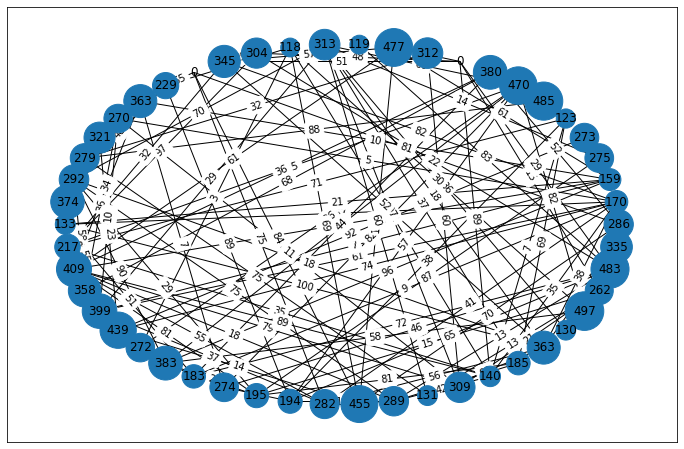

[(9, 11, 86), (9, 15, 48), (9, 16, 51), (9, 42, 89), (9, 47, 15), (9, 48, 29)]
{'mean': 275, 'std': 48, 'is_farm': True, 'is_dropoff': False, 'is_fuel_station': False, 'waste': 236.2870009723707}
100


In [166]:

class Network:
    def __init__(self, n = n, m = m, w_max = w_max, seed = seed):

        self.G = nx.erdos_renyi_graph(n, m/(n - 1), seed = seed)
        #make sure the network is always connected
        while not nx.is_connected(self.G):
            self.G = nx.erdos_renyi_graph(n, m/(n - 1), seed = seed)


        for (u, v) in self.G.edges():
            self.G.edges[u,v]['weight'] = random.randint(1, w_max)
        for node_idx in self.G.nodes():
            node = self.G.nodes[node_idx]
            node["mean"] = random.randint(average_waste_lower, average_waste_upper)
            node["std"] = random.randint(std_waste_lower, std_waste_upper)
            node["is_farm"] = True
            node["is_dropoff"] = False
            node["is_fuel_station"] = False
            logger.info(node)

        #choose 2 random nodes to be the dropoff site and fuel site
        self.dropoff_node_idx, self.fuel_station_node_idx = random.sample(set(self.G.nodes()), 2)
        dropoff_node = self.G.nodes[self.dropoff_node_idx]
        dropoff_node["mean"] = 0
        dropoff_node["std"] = 0
        dropoff_node["is_farm"] = False
        dropoff_node["is_dropoff"] = True

        fuel_station_node = self.G.nodes[self.fuel_station_node_idx]
        fuel_station_node["mean"] = 0
        fuel_station_node["std"] = 0
        fuel_station_node["is_farm"] = False
        fuel_station_node["is_fuel_station"] = True

        self.update_daily_waste()


    def get_dist_to_dropoff(self, node_idx):
        return nx.dijkstra_path_length(self.G, node_idx, self.dropoff_node_idx)


    def get_dist_to_fuel(self, node_idx):
        return nx.dijkstra_path_length(self.G, node_idx, self.fuel_station_node_idx)

    
    def get_dist_between_nodes(self, node_1, node_2):
        return nx.dijkstra_path_length(self.G, node_1, node_2)


    def update_daily_waste(self):
        #get values for node
        for idx in self.G.nodes():
            node = self.G.nodes[idx]
            node["waste"] = np.random.normal(loc=node["mean"], scale=node["std"])


    def draw(self):
        plt.figure(figsize=(12, 8))
        pos=nx.circular_layout(self.G) 
        
        nodes_mean = nx.get_node_attributes(self.G, 'mean')
        node_size = [val * 3 for val in nodes_mean.values()]
        edges_labels = nx.get_edge_attributes(self.G,'weight')

        nx.draw_networkx(self.G,pos, labels=nodes_mean, node_size = node_size, with_labels=True)
        nx.draw_networkx_edge_labels(self.G,pos,edge_labels=edges_labels)  

        plt.show()      


test = Network()
test.draw()
print(test.G.edges(test.dropoff_node_idx, data="weight"))
print(test.G.nodes[3])
print(test.get_dist_to_dropoff(3))



In [167]:
max_fuel = 1000
max_waste = 3000

class Truck:
    def __init__(self, graph, max_fuel = max_fuel, max_waste = max_waste):
        self.graph = graph

        self.fuel_node = graph.fuel_station_node_idx
        self.dropoff_node = graph.dropoff_node_idx

        self.max_fuel = max_fuel
        self.current_fuel = max_fuel

        self.max_waste = max_waste
        self.current_waste = 0

    def refuel(self, current_node_idx):
        dist_travel = self.graph.get_dist_to_fuel(current_node_idx)
        logger.info(f"\tGoing to refuel. Fuel level: {self.current_fuel}. Distance to fuel station: {dist_travel}")
        if self.current_fuel < dist_travel:
            return False
        self.current_fuel = self.max_fuel
        logger.info(f"\tRefuel complete. Fuel level: {self.current_fuel}")
        return dist_travel

    def dropoff_waste(self, current_node_idx):
        logger.info(f"\tGoing to dropoff. Waste level: {self.current_waste}")
        dist_travel = self.graph.get_dist_to_dropoff(current_node_idx)
        if self.current_fuel < dist_travel:
            raise ValueError("Does not have enough fuel to go to waste dropoff.")
        self.current_fuel -= dist_travel
        self.current_waste = 0
        logger.info(f"\tDropoff complete. Waste level: {self.current_waste}")
        return dist_travel

    def setup_day(self):
        total_fuel_used = 0
        cur_loc = self.fuel_node
        self.current_fuel = self.max_fuel
        self.current_waste = 0

        return total_fuel_used, cur_loc

    def run_one_day(self):
        raise Exception("Not implemented")



In [168]:


def default_algo(graph):
    return nx.approximation.traveling_salesman_problem(graph.G)

class FixedTruck(Truck):
    def __init__(self, graph, max_fuel = max_fuel, max_waste = max_waste, algorithm = default_algo):
        super().__init__(graph, max_fuel, max_waste)

        self.path = algorithm(graph)
        logger.info(self.path)

        self.max_dist_to_fuel = max(self.graph.get_dist_to_fuel(node) for node in self.graph.G.nodes())


    def run_one_day(self):
        total_fuel_used, cur_loc = self.setup_day()
        cur_path_idx = 0


        while cur_path_idx < len(self.path):
            #sanity check
            if self.current_fuel <= 0:
                raise ValueError("Fuel is below 0. Truck is dead.")
            if self.current_waste > self.max_waste:
                raise ValueError("Waste overflow.")

            logger.info(f"Truck currently at {cur_loc}. Fuel: {self.current_fuel}. Waste: {self.current_waste}")

            next_loc = self.path[cur_path_idx]
            dist = self.graph.get_dist_between_nodes(cur_loc, next_loc)

            #if we don't have enough fuel, refuel first
            if self.current_fuel < self.max_dist_to_fuel + dist + self.graph.get_dist_to_fuel(cur_loc):
                refuel = self.refuel(cur_loc)
                if refuel is False:
                    total_fuel_used, cur_loc = self.setup_day()
                    cur_path_idx = 0
                    continue
                total_fuel_used += refuel
                cur_loc = self.fuel_node
                continue
            
            #if we are at maximum waste capacity, dropoff waste
            if self.current_waste == self.max_waste:
                total_fuel_used += self.dropoff_waste(cur_loc)
                cur_loc = self.dropoff_node
                continue
            
            #travel to next location
            total_fuel_used += dist
            self.current_fuel -= dist

            cur_loc = next_loc

            #remove waste
            waste_remove = min(self.graph.G.nodes[cur_loc]["waste"], self.max_waste - self.current_waste)
            self.graph.G.nodes[cur_loc]["waste"] -= waste_remove
            self.current_waste += waste_remove
            
            #we move on the next index only after we clear all the waste in the location
            if self.graph.G.nodes[cur_loc]["waste"] == 0:
                cur_path_idx += 1

        #remove all waste left
        total_fuel_used += self.dropoff_waste(cur_loc)
        
        #sanity check
        for node in self.graph.G.nodes():
            if self.graph.G.nodes[node]["waste"] > 0:
                raise ValueError(f"Waste at {node} not removed")

        return total_fuel_used

test_truck = FixedTruck(test)
print("Dropoff", test_truck.dropoff_node)
print("Fuel", test_truck.fuel_node)
test_truck.run_one_day()

Dropoff 9
Fuel 17


4439

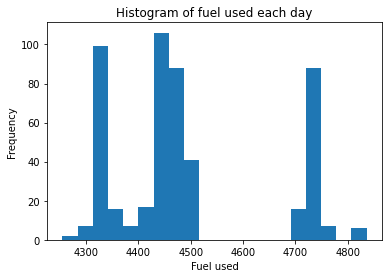

Mean: 4486.69
Std: 6.4458872721643905
95% Confidence interval: [4474.025575825385, 4499.354424174614]


In [169]:

class Simulation:
    def __init__(self, network, truck):
        self.network = network
        self.truck = truck
        self.day = 0
        self.fuel_storage = []


    def run_one_day(self):
        self.day += 1
        self.network.update_daily_waste()
        fuel_used = self.truck.run_one_day()
        self.fuel_storage.append(fuel_used)

    def run(self, days):
        for i in range(days):
            self.run_one_day()
        return self.fuel_storage

    def plot(self):
        plt.hist(self.fuel_storage, bins = 20)
        plt.title("Histogram of fuel used each day")
        plt.xlabel("Fuel used")
        plt.ylabel("Frequency")
        plt.show()

    def summarize(self):
        mean = np.mean(self.fuel_storage)
        std = st.sem(self.fuel_storage)
        lower_bound, upper_bound = st.t.interval(0.95, len(self.fuel_storage)-1, loc=mean, scale=std)
        print(f"Mean: {mean}\nStd: {std}\n95% Confidence interval: [{lower_bound}, {upper_bound}]")

simulation = Simulation(test, test_truck)
simulation.run(500)
simulation.plot()
simulation.summarize()


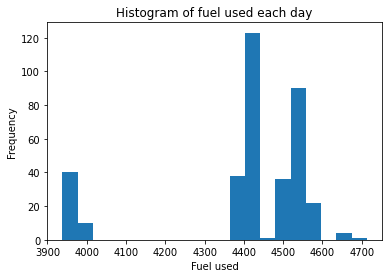

Mean: 4411.8794520547945
Std: 9.610645619672681
95% Confidence interval: [4392.980092755889, 4430.7788113537]


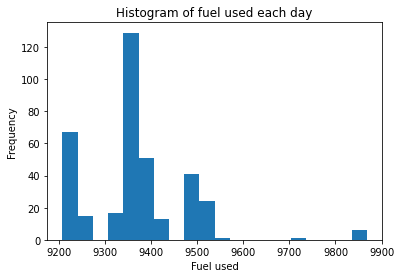

Mean: 9366.405479452054
Std: 6.0625260747772725
95% Confidence interval: [9354.483506352592, 9378.327452551517]


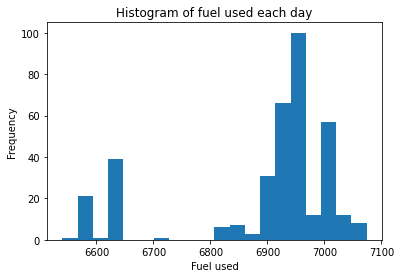

Mean: 6895.65205479452
Std: 7.253000236199166
95% Confidence interval: [6881.389011198533, 6909.915098390507]


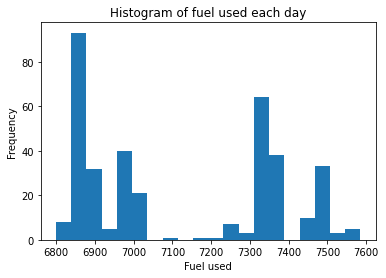

Mean: 7127.945205479452
Std: 12.872475441654872
95% Confidence interval: [7102.631449456632, 7153.258961502272]


In [170]:
def minimize_dist_to_fuel(graph):
    for node in graph.G.nodes():
        graph.G.nodes[node]["dist_to_fuel"] = graph.get_dist_to_fuel(node)
    return nx.approximation.traveling_salesman_problem(graph.G, weight = "dist_to_fuel")


def minimize_dist_to_dropoff(graph):
    for node in graph.G.nodes():
        graph.G.nodes[node]["dist_to_dropoff"] = graph.get_dist_to_dropoff(node)
    return nx.approximation.traveling_salesman_problem(graph.G, weight = "dist_to_dropoff")

def maximize_waste(graph):
    for node in graph.G.nodes():
        graph.G.nodes[node]["waste_neg"] = -graph.G.nodes[node]["waste"]
    return nx.approximation.traveling_salesman_problem(graph.G, weight = "waste_neg")

for algo in [default_algo, minimize_dist_to_fuel, minimize_dist_to_dropoff, maximize_waste]:
    network = Network()
    truck = FixedTruck(network, algorithm = algo)
    simulation = Simulation(network, truck)
    simulation.run(365)
    simulation.plot()
    simulation.summarize()

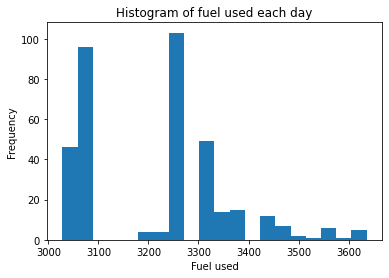

Mean: 3219.139726027397
Std: 7.4842178642986825
95% Confidence interval: [3204.4219923718006, 3233.8574596829935]


In [171]:
class FlexibleTruck(Truck):
    def __init__(self, graph, max_fuel = max_fuel, max_waste = max_waste):
        super().__init__(graph, max_fuel, max_waste)
        self.max_dist_to_fuel = max(self.graph.get_dist_to_fuel(node) for node in self.graph.G.nodes())
        self.shortest_path = dict(nx.all_pairs_dijkstra_path_length(self.graph.G))

    def __repr__(self):
        return "Flexible Truck"

    def run_one_day(self):
        total_fuel_used, cur_loc = self.setup_day()
        visited = set([self.dropoff_node, self.fuel_node])

        while len(visited) < len(self.graph.G.nodes()):
            #sanity check
            if self.current_fuel <= 0:
                raise ValueError("Fuel is below 0. Truck is dead.")
            if self.current_waste > self.max_waste:
                raise ValueError("Waste overflow.")

            logger.info(f"Truck currently at {cur_loc}. Fuel: {self.current_fuel}. Waste: {self.current_waste}")

            #greedy algorithm to go to closest node first
            potential_next_locs = [loc for loc in range(len(self.graph.G.nodes())) if (
                loc not in visited and loc != self.fuel_node 
                and loc != self.dropoff_node and loc != cur_loc
                )]
            dist, next_loc = min([(self.shortest_path[cur_loc][loc], loc) 
                                for loc in potential_next_locs], default = (0, 0))

            #if we don't have enough fuel, refuel first
            if self.current_fuel < self.max_dist_to_fuel + dist + self.graph.get_dist_to_fuel(cur_loc):
                refuel = self.refuel(cur_loc)
                if refuel is False:
                    total_fuel_used, cur_loc = self.setup_day()
                    cur_path_idx = 0
                    continue
                total_fuel_used += refuel
                cur_loc = self.fuel_node
                continue
            
            #if we are at maximum waste capacity, dropoff waste
            if self.current_waste == self.max_waste:
                total_fuel_used += self.dropoff_waste(cur_loc)
                cur_loc = self.dropoff_node
                continue
            
            #travel to next location
            total_fuel_used += dist
            self.current_fuel -= dist

            cur_loc = next_loc

            #remove waste
            waste_remove = min(self.graph.G.nodes[cur_loc]["waste"], self.max_waste - self.current_waste)
            self.graph.G.nodes[cur_loc]["waste"] -= waste_remove
            self.current_waste += waste_remove
            
            #we move on the next index only after we clear all the waste in the location
            if self.graph.G.nodes[cur_loc]["waste"] == 0:
                visited.add(cur_loc)
            
        #remove all waste left
        total_fuel_used += self.dropoff_waste(cur_loc)
        #sanity check
        for node in self.graph.G.nodes():
            if self.graph.G.nodes[node]["waste"] > 0:
                raise ValueError(f"Waste at {node} not removed")

        return total_fuel_used


network = Network()           
truck = FlexibleTruck(network)
truck.run_one_day()

simulation = Simulation(network, truck)
simulation.run(365)
simulation.plot()
simulation.summarize()

<class '__main__.FixedTruck'>
Mean: 3728.290410958904
Std: 5.653449159899675
95% Confidence interval: [3717.1728886633855, 3739.4079332544225]

<class '__main__.FlexibleTruck'>
Mean: 3339.0219178082193
Std: 11.411878840014538
95% Confidence interval: [3316.5804287545047, 3361.463406861934]



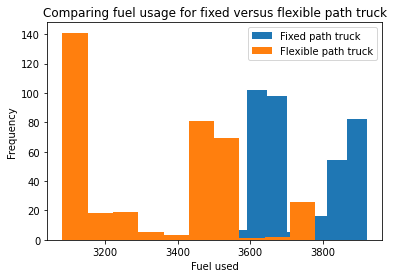

Ttest_indResult(statistic=30.56566967806202, pvalue=2.979655753243193e-119)

In [172]:
#t test
network = Network()
fuels = []

for TruckClass in [FixedTruck, FlexibleTruck]:
    truck = TruckClass(network)
    simulation = Simulation(network, truck)
    simulation.run(365)
    print(TruckClass)
    simulation.summarize()
    print()
    fuels.append(simulation.fuel_storage)

plt.hist(fuels[0], label = "Fixed path truck")
plt.hist(fuels[1], label = "Flexible path truck")
plt.xlabel("Fuel used")
plt.ylabel("Frequency")
plt.title("Comparing fuel usage for fixed versus flexible path truck")
plt.legend()
plt.show()
st.ttest_ind(fuels[0], fuels[1], equal_var = False)



In [173]:
#effect size
def cohend(d1, d2) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)

    # return the effect size
    return (u1 - u2) / s

cohend(fuels[0], fuels[1])

2.262572378763145